In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam



Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [26]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)



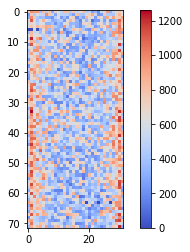

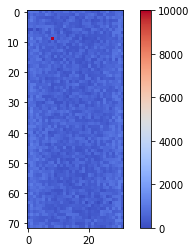

In [4]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    a=np.random.randint(input_images.shape[2]-1)
    b=np.random.randint(input_images.shape[1]-1)

    xdim=(a,a+1)
    ydim=(b,b+1)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(2997, 72, 32)



For CNN

create the corresponding label matrices


In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1

In [7]:
#this is because I am only going to add the hot and dead region images

for i in range(2,0,-1):
    y[-i*input_images.shape[0]:]=3-i
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,3)

In [8]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (2997, 72, 32)
y shape is:  (2997, 3)


Xtrain.shape (1798, 72, 32)
Xtest.shape (1199, 72, 32)
ytrain.shape (1798, 3)
ytest.shape (1199, 3)
Printing labels and their corresponding images
-------------------
[ 0.  1.  0.]


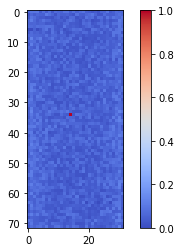

-------------------
[ 0.  1.  0.]


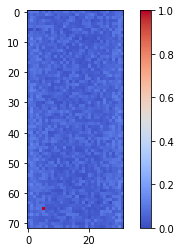

-------------------
[ 1.  0.  0.]


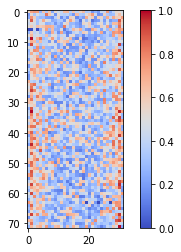

-------------------
[ 0.  1.  0.]


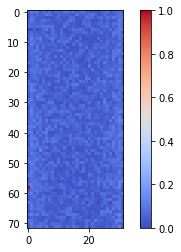

-------------------
[ 1.  0.  0.]


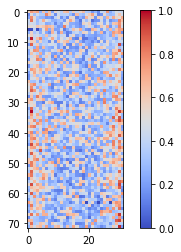

-------------------
[ 1.  0.  0.]


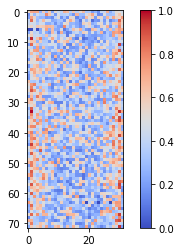

-------------------
[ 1.  0.  0.]


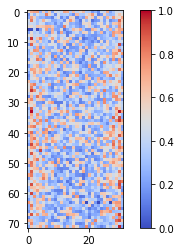

-------------------
[ 0.  0.  1.]


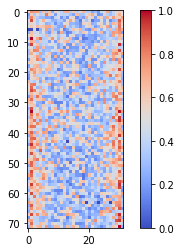

-------------------
[ 0.  1.  0.]


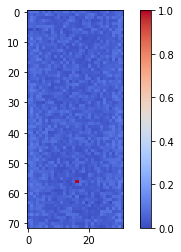

-------------------
[ 0.  1.  0.]


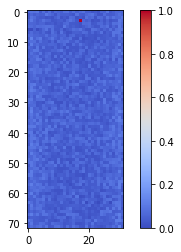

Xtrain.shape after if statement (1798, 72, 32, 1)
Xtest.shape after if statement (1199, 72, 32, 1)
ytrain.shape after if statement (1798, 3)
ytest.shape after if statement (1199, 3)


In [9]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating the model

In [10]:
# this is the dummy model
model = Sequential()

model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8,kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(8))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 71, 31, 10)        50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 71, 31, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 71, 31, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 15, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 13, 8)         728       
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 13, 8)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 33, 13, 8)         0         
__________

In [11]:
ypred=model.predict(Xtest)
ypredproba=model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [12]:
print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

[[0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]] 


[[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [0]
 [2]
 [2]
 [2]]


0.336947456214
Confusion matrix, without normalization
[[  0   0 403]
 [ 73   8 319]
 [  0   0 396]]


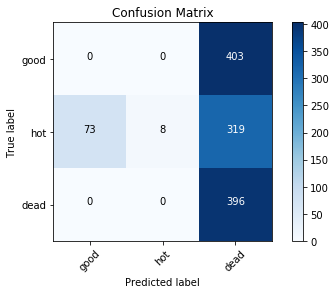

In [13]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
print metrics.accuracy_score(ytestclass,ypredclass)
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','hot','dead']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')

0.339487449655 For the label #0
0.985819774718 For the label #1
0.750466998755 For the label #2


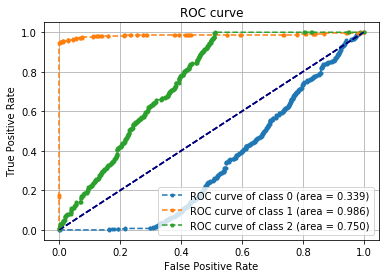

In [14]:
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = %0.3f)'.format(i) % roc_auc,marker='.')#, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

In [15]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_hot_dead.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [ ]:
history = model.fit(Xtrain,ytrain,epochs=300
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 1798 samples, validate on 1199 samples
Epoch 1/300
Epoch 00001: val_loss improved from inf to 1.10768, saving model to best_nbmodel_good_hot_dead.hdf5
 - 23s - loss: 0.7349 - acc: 0.6613 - val_loss: 1.1077 - val_acc: 0.3336
Epoch 2/300
Epoch 00002: val_loss did not improve
 - 16s - loss: 0.5749 - acc: 0.6707 - val_loss: 1.2441 - val_acc: 0.3336
Epoch 3/300
Epoch 00003: val_loss did not improve
 - 16s - loss: 0.5182 - acc: 0.6735 - val_loss: 1.3715 - val_acc: 0.3336
Epoch 4/300
Epoch 00004: val_loss did not improve
 - 16s - loss: 0.4956 - acc: 0.6824 - val_loss: 1.3270 - val_acc: 0.3336
Epoch 5/300
Epoch 00005: val_loss did not improve
 - 16s - loss: 0.4870 - acc: 0.6663 - val_loss: 1.3861 - val_acc: 0.3336
Epoch 6/300
Epoch 00006: val_loss improved from 1.10768 to 0.81201, saving model to best_nbmodel_good_hot_dead.hdf5
 - 16s - loss: 0.4800 - acc: 0.6713 - val_loss: 0.8120 - val_acc: 0.3545
Epoch 7/300
Epoch 00007: val_loss improved from 0.81201 to 0.52642, saving model to be

Epoch 59/300
Epoch 00059: val_loss did not improve
 - 16s - loss: 0.2740 - acc: 0.8771 - val_loss: 0.3403 - val_acc: 0.8057
Epoch 60/300
Epoch 00060: val_loss improved from 0.31801 to 0.29577, saving model to best_nbmodel_good_hot_dead.hdf5
 - 16s - loss: 0.2831 - acc: 0.8665 - val_loss: 0.2958 - val_acc: 0.8774
Epoch 61/300
Epoch 00061: val_loss improved from 0.29577 to 0.28740, saving model to best_nbmodel_good_hot_dead.hdf5
 - 16s - loss: 0.2841 - acc: 0.8726 - val_loss: 0.2874 - val_acc: 0.8824
Epoch 62/300
Epoch 00062: val_loss did not improve
 - 16s - loss: 0.2879 - acc: 0.8665 - val_loss: 0.3208 - val_acc: 0.8457
Epoch 63/300
Epoch 00063: val_loss did not improve
 - 16s - loss: 0.2662 - acc: 0.8843 - val_loss: 0.3477 - val_acc: 0.8282
Epoch 64/300
Epoch 00064: val_loss did not improve
 - 16s - loss: 0.2614 - acc: 0.8927 - val_loss: 0.3326 - val_acc: 0.8465
Epoch 65/300
Epoch 00065: val_loss improved from 0.28740 to 0.26721, saving model to best_nbmodel_good_hot_dead.hdf5
 - 16s 

Epoch 116/300
Epoch 00116: val_loss improved from 0.18661 to 0.18604, saving model to best_nbmodel_good_hot_dead.hdf5
 - 16s - loss: 0.1899 - acc: 0.9271 - val_loss: 0.1860 - val_acc: 0.9333
Epoch 117/300
Epoch 00117: val_loss did not improve
 - 16s - loss: 0.1898 - acc: 0.9316 - val_loss: 0.2015 - val_acc: 0.9258
Epoch 118/300
Epoch 00118: val_loss did not improve
 - 16s - loss: 0.1905 - acc: 0.9294 - val_loss: 0.2315 - val_acc: 0.9099
Epoch 119/300
Epoch 00119: val_loss did not improve
 - 16s - loss: 0.1769 - acc: 0.9383 - val_loss: 0.2741 - val_acc: 0.8841
Epoch 120/300
Epoch 00120: val_loss did not improve
 - 16s - loss: 0.1822 - acc: 0.9349 - val_loss: 0.2123 - val_acc: 0.9191
Epoch 121/300
Epoch 00121: val_loss did not improve
 - 16s - loss: 0.1716 - acc: 0.9377 - val_loss: 0.2079 - val_acc: 0.9208
Epoch 122/300
Epoch 00122: val_loss did not improve
 - 16s - loss: 0.1855 - acc: 0.9310 - val_loss: 0.2073 - val_acc: 0.9291
Epoch 123/300
Epoch 00123: val_loss did not improve
 - 16s 

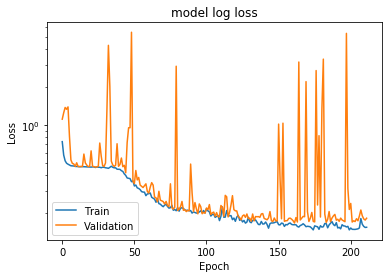

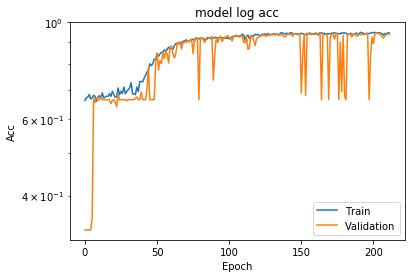

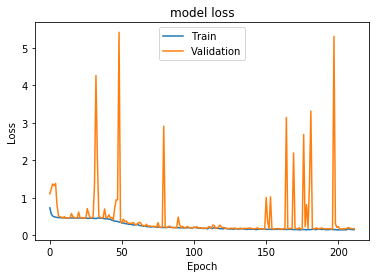

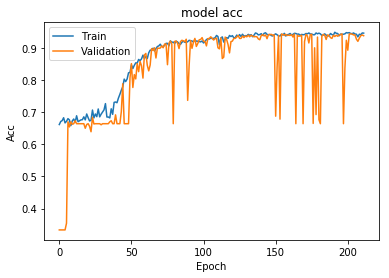

In [ ]:

u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")


# Loading and Evaluation of a trained model

In [ ]:
best_model= load_model('best_nbmodel_good_hot_dead.hdf5',compile=False)

In [ ]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [ ]:
np.all(ypredproba==ypred)
#this confirms my suspicions

True

Confusion matrix, without normalization
[[402   0   1]
 [  0 400   0]
 [ 70   0 326]]
accuracy score:  0.940783986656


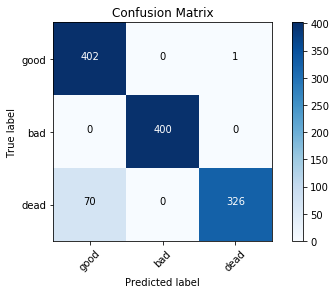

In [ ]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad','dead']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)


0.959585458309 For the label #0
1.0 For the label #1
0.95922959357 For the label #2


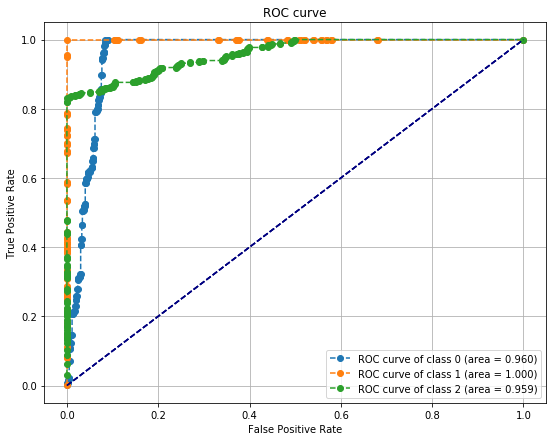

In [24]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

# Loading and using real bad data

In [27]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ_run315488_corrupted.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])




print data_sample.shape
bad_data_sample=data_sample[:,:,26:58]

for k in bad_data_sample[:10]:
    
    print ''
    
    im=plt.imshow(k,cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()

IOError: Unable to open file (Unable to open file: name = '../../data/hcal_digi+rechit_occ_run315488_corrupted.hdf5', errno = 34, error message = 'numerical result out of range', flags = 1, o_flags = 2)

In [ ]:
BadX=np.copy(bad_data_sample)
print BadX.shape
Bady=np.zeros((bad_data_sample.shape[0],1))

In [ ]:
if K.image_data_format() == 'channels_first':
        BadX = BadX.reshape(BadX.shape[0], 1, img_rows, img_cols)
else:
        BadX = BadX.reshape(BadX.shape[0], img_rows, img_cols, 1)

In [ ]:
ybadpredclass=best_model.predict_classes(BadX)
print ybadpredclass.shape
ybadpredclass=ybadpredclass.reshape(ybadpredclass.shape[0],1)

In [ ]:
print ybadpredclass[:5].shape

In [ ]:
print ybadpredclass

In [ ]:
bconfm= metrics.confusion_matrix(Bady,ybadpredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(bconfm,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(Bady,ybadpredclass)
